In [1]:
#!/usr/bin/env python
# coding: utf-8

import glob
import re
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="pastel", color_codes=True, font='Helvetica')

# Set font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIG_SIZE = 10

plt.rcParams.update({
    'legend.loc': 'center left',
    'font.family': 'Helvetica',
    'pdf.fonttype': 42,
    'font.size': BIG_SIZE,         # controls default text sizes
    'axes.titlesize': SMALL_SIZE,  # fontsize of the axes title
    'axes.labelsize': MEDIUM_SIZE, # fontsize of the x and y labels
    'xtick.labelsize': SMALL_SIZE, # fontsize of the tick labels
    'ytick.labelsize': SMALL_SIZE, # fontsize of the tick labels
    'legend.fontsize': SMALL_SIZE, # legend fontsize
    'figure.titlesize': BIG_SIZE,   # fontsize of the figure title
    'figure.figsize': (6,3),
    'figure.dpi': 120
})



aa_ordering = ['W','Y','F','M','L','I','V','A','C','G',
               'P','T','S','Q','N','E','D','H','R','K','*']
bin_ordering = ['drop-outs','toxic','STOP-like','intermediate','neutral','beneficial']

# res2seq = (pd.read_csv('../data/ddg/residue_number_map.txt')
#            .set_index('resnum').to_dict()['seqnum']
#           )
# aa1 = ['W','Y','F','M','L','I','V','A','C','G',
#        'P','T','S','Q','N','E','D','H','R','K']
# aa3 = ['TRP', 'TYR', 'PHE', 'MET', 'LEU',
#        'ILE', 'VAL', 'ALA', 'CYS', 'GLY',
#        'PRO', 'THR', 'SER', 'GLN', 'ASN',
#        'GLU', 'ASP', 'HIS', 'ARG', 'LYS']
# aa3to1 = dict(zip(aa3,aa1))
# aa3to1['H2S'] = 'H'
# aa3to1['H1S'] = 'H'

In [2]:
df_ddg = pd.read_csv('../data/20200806_gsp1_ddg.csv')  # rosetta ddG scores
df_fit = pd.read_csv('../../Data/15gen_fitness_current.csv')  # empiric fitnesses, binned
# df_fit = pd.read_csv('../../Data/6gen_fitness_current.csv')  # empiric fitnesses, binned
df_con = pd.read_csv('../data/conservation.csv')       # conservation from consurf
df_bur = pd.read_csv('../data/burial.csv')             # burial, based on SASA across all structures


df = (
    pd.merge(df_fit, df_ddg, how='left', left_on='mutant', right_on='mutation')
    .merge(df_con, how='left', on=['position','aa_to'])
    .merge(df_bur, how='left')
    #   .loc[1000:1020]
    .drop(['mutation'], axis='columns')
    .assign(aa_to = lambda df: df.aa_to.astype('category').cat.set_categories(aa_ordering),
            aa_from = lambda df: df.aa_from.astype('category').cat.set_categories(aa_ordering),
            bin = lambda df: (
                df.bin.astype('category')
                .cat.set_categories(bin_ordering)
                .fillna('drop-outs'))
           )
    .rename(columns={'score': 'fitness'})
)

corr_no_NA = df['ddg'].corr(df['fitness'])
df.fitness = df.fitness.fillna(min(df.fitness)-1)
corr_w_NA = df['ddg'].corr(df['fitness'])

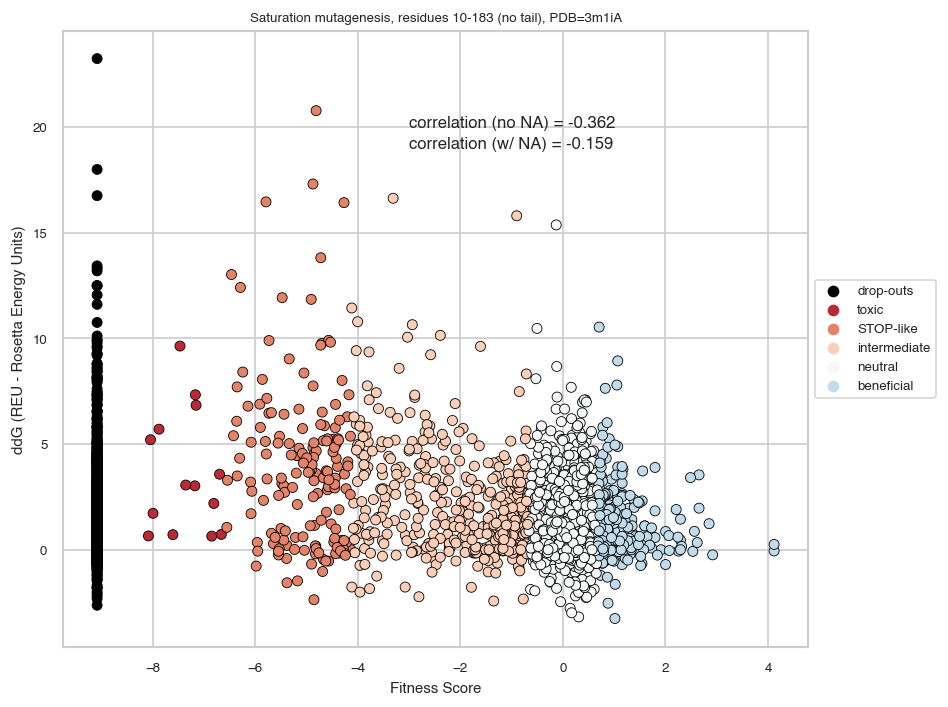

In [4]:
# prepare figure
fig, ax = plt.subplots(figsize=(8,6))



sns.scatterplot(data=df, x='fitness', y='ddg', hue='bin', hue_order = bin_ordering,
                palette=[(0,0,0)]+sns.color_palette('RdBu', n_colors=7)[:5],
                edgecolor='black', linewidth=0.5
               )

ax.text(-3,20,'correlation (no NA) = {}'.format(round(corr_no_NA,3)))
ax.text(-3,19,'correlation (w/ NA) = {}'.format(round(corr_w_NA,3)))

plt.title('Saturation mutagenesis, residues 10-183 (no tail), PDB=3m1iA')
plt.xlabel('Fitness Score')
plt.ylabel('ddG (REU - Rosetta Energy Units)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout(rect=[0, 0, 1, 1])
# fig.savefig('satmut_ddG_2020-07-26.png', dpi=300)

In [6]:
df[df.mutant.isin(['G35D', 'G35A','H32I','H32L'])]

,mutant,aa_from,position,aa_to,fitness,bin,ddg,consurf,consurf_score,exists_in_msa,region3,sasa_group_category
655,H32L,H,32,L,0.735151,beneficial,-1.212030,7.0,-0.743,yes,effector structure core,structure core
656,H32I,H,32,I,-9.081131,drop-outs,0.764966,7.0,-0.743,yes,effector structure core,structure core
723,G35A,G,35,A,-1.376958,intermediate,1.423840,5.0,0.140,yes,effector interface core,interface core
733,G35D,G,35,D,-9.081131,drop-outs,1.496560,5.0,0.140,yes,effector interface core,interface core


### how about conservation?

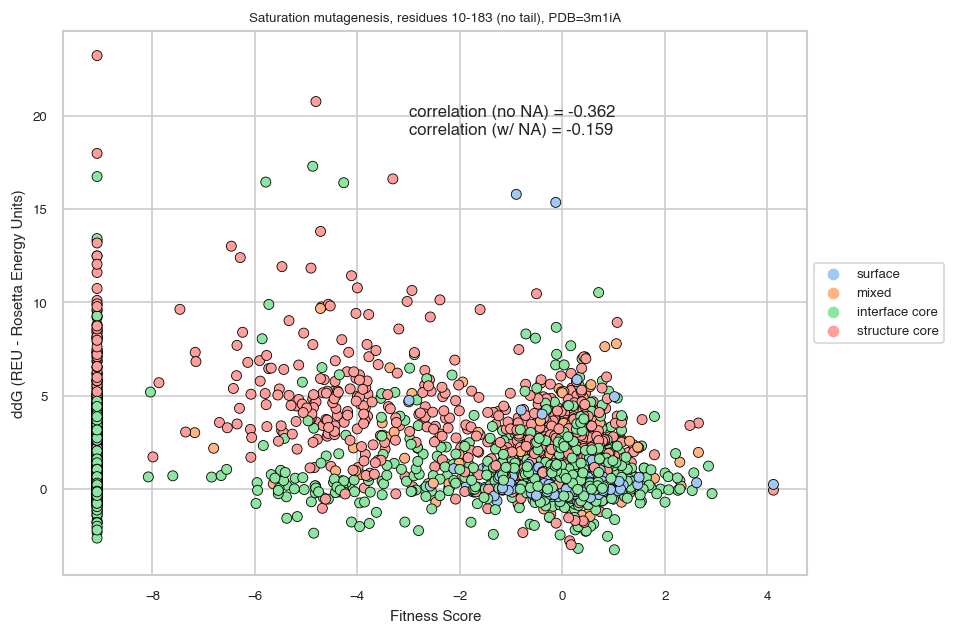

In [4]:
# prepare figure
fig, ax = plt.subplots(figsize=(8,6))



sns.scatterplot(data=df, x='fitness', y='ddg', hue='sasa_group_category',
#                 hue_order = bin_ordering,
#                 palette=[(0,0,0)]+sns.color_palette('RdBu', n_colors=7)[:4],
                edgecolor='black', linewidth=0.5
               )

ax.text(-3,20,'correlation (no NA) = {}'.format(round(corr_no_NA,3)))
ax.text(-3,19,'correlation (w/ NA) = {}'.format(round(corr_w_NA,3)))

plt.title('Saturation mutagenesis, residues 10-183 (no tail), PDB=3m1iA')
plt.xlabel('Fitness Score')
plt.ylabel('ddG (REU - Rosetta Energy Units)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# fig.tight_layout(rect=[0, 0, 1, 1])
# fig.savefig('satmut_ddG_2020-07-26.png', dpi=300)

## core vs surface vs interface

In [30]:
# compute regression line with no NAs for structure core


df2 = (df
 [df.sasa_group_category == 'structure core']
 [df.bin != 'drop-outs']
)


import statsmodels.formula.api as sm
result = sm.ols(formula="ddg ~ fitness", data=df2).fit()
print(result.params)
print(result.summary())

m = -0.575
b = 2.155
r_sq = 0.239


Intercept    2.155104
fitness     -0.574763
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    ddg   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     286.6
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           4.17e-56
Time:                        21:31:47   Log-Likelihood:                -1943.8
No. Observations:                 913   AIC:                             3892.
Df Residuals:                     911   BIC:                             3901.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

<ipython-input-30-25d035783ca4>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = (df


In [27]:
X_plot = np.linspace(-8,3,100)
X_plot

array([-8.        , -7.88888889, -7.77777778, -7.66666667, -7.55555556,
       -7.44444444, -7.33333333, -7.22222222, -7.11111111, -7.        ,
       -6.88888889, -6.77777778, -6.66666667, -6.55555556, -6.44444444,
       -6.33333333, -6.22222222, -6.11111111, -6.        , -5.88888889,
       -5.77777778, -5.66666667, -5.55555556, -5.44444444, -5.33333333,
       -5.22222222, -5.11111111, -5.        , -4.88888889, -4.77777778,
       -4.66666667, -4.55555556, -4.44444444, -4.33333333, -4.22222222,
       -4.11111111, -4.        , -3.88888889, -3.77777778, -3.66666667,
       -3.55555556, -3.44444444, -3.33333333, -3.22222222, -3.11111111,
       -3.        , -2.88888889, -2.77777778, -2.66666667, -2.55555556,
       -2.44444444, -2.33333333, -2.22222222, -2.11111111, -2.        ,
       -1.88888889, -1.77777778, -1.66666667, -1.55555556, -1.44444444,
       -1.33333333, -1.22222222, -1.11111111, -1.        , -0.88888889,
       -0.77777778, -0.66666667, -0.55555556, -0.44444444, -0.33

In [34]:
result.params

Intercept    2.155104
fitness     -0.574763
dtype: float64

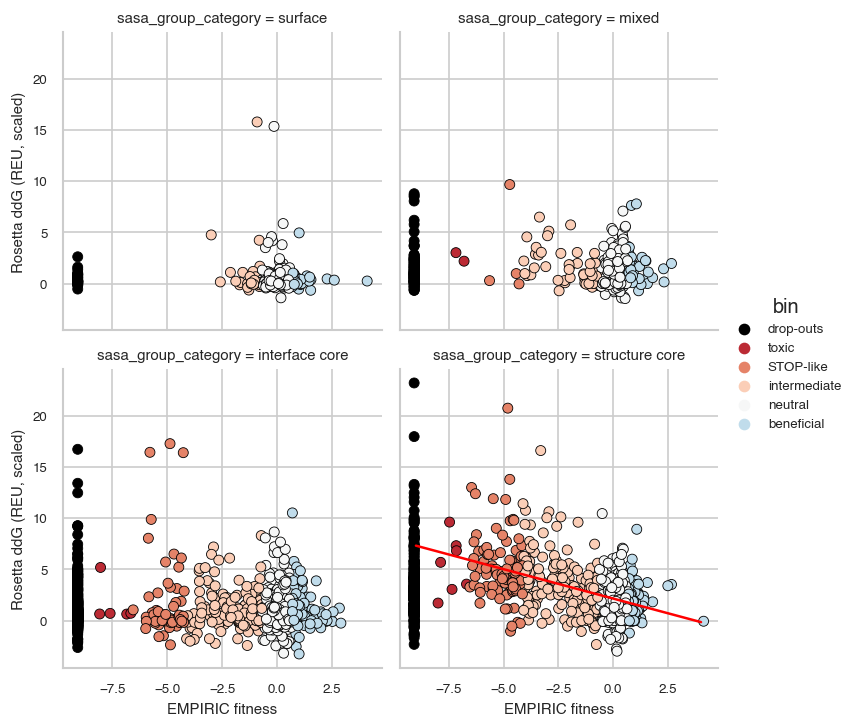

In [40]:
g = sns.relplot(data=df, x='fitness', y='ddg', col='sasa_group_category', col_wrap=2,
                hue='bin', hue_order = bin_ordering,
                palette=[(0,0,0)]+sns.color_palette('RdBu', n_colors=7)[:5],
                edgecolor='black', linewidth=0.5, aspect=1, height=3
               )
g.set_axis_labels('EMPIRIC fitness', 'Rosetta ddG (REU, scaled)')


X_plot = np.linspace(-9,4,100)
g.axes[3].plot(X_plot, X_plot*result.params[1] + result.params[0], color='red')



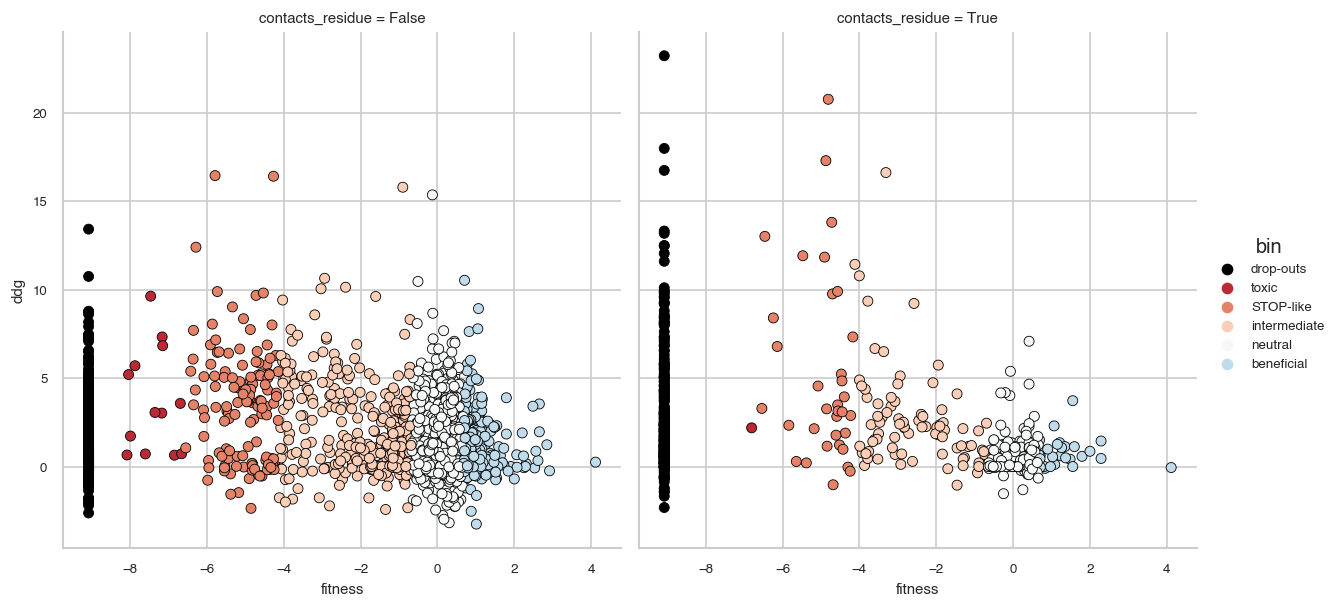

In [67]:
contacting_residues = [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 37, 38, 39, 40, 41, 42,
                       43, 44, 67, 68, 69, 70, 71, 124, 125, 127, 128, 152, 153, 154]

# prepare figure
# fig, ax = plt.subplots(figsize=(8,6))

df_cr = (df
         .assign(contacts_residue=lambda df: df.position.apply(lambda row: True if row in contacting_residues else False))
        )

sns.relplot(data=df_cr, x='fitness', y='ddg', col='contacts_residue',col_wrap=2,
            hue='bin', hue_order = bin_ordering,
            palette=[(0,0,0)]+sns.color_palette('RdBu', n_colors=7)[:5],
            edgecolor='black', linewidth=0.5
            )

# ax.text(-3,20,'correlation (no NA) = {}'.format(round(corr_no_NA,3)))
# ax.text(-3,19,'correlation (w/ NA) = {}'.format(round(corr_w_NA,3)))

# plt.title('Saturation mutagenesis, residues 10-183 (no tail), PDB=3m1iA')
# plt.xlabel('Fitness Score')
# plt.ylabel('ddG (REU - Rosetta Energy Units)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# fig.tight_layout(rect=[0, 0, 1, 1])
# fig.savefig('satmut_ddG_2020-07-26.png', dpi=300)

### which interface core resides did rosetta get right?

In [68]:
(df
 .loc[df['sasa_group_category'] == 'interface core']
 .loc[df['ddg'] > 5]
 .loc[df['bin'].isin(['drop-outs','toxic','STOP-like'])]
 ['position']
 .drop_duplicates()
 .values
)

array([ 22,  33,  35,  46,  58,  59,  69,  74,  76,  95,  96, 102, 125,
       127, 128, 155, 170])

### which interface core resides did rosetta get right?

In [69]:
(df
 .loc[df['sasa_group_category'] == 'interface core']
 .loc[df['ddg'] < 5]
 .loc[df['bin'].isin(['drop-outs','toxic','STOP-like'])]
 ['position']
 .drop_duplicates()
 .values
)

array([ 21,  22,  33,  35,  36,  37,  41,  43,  45,  46,  48,  49,  53,
        57,  59,  66,  69,  72,  73,  75,  77,  78,  79,  80,  83,  95,
        96,  97,  98, 101, 102, 104, 105, 109, 112, 113, 125, 127, 128,
       130, 131, 132, 135, 137, 141, 145, 147, 154, 155, 156, 157, 159,
       160, 161, 168, 171, 173, 178, 179, 180, 181, 182, 183])

### what about conservation?

<AxesSubplot:xlabel='consurf', ylabel='ddg'>

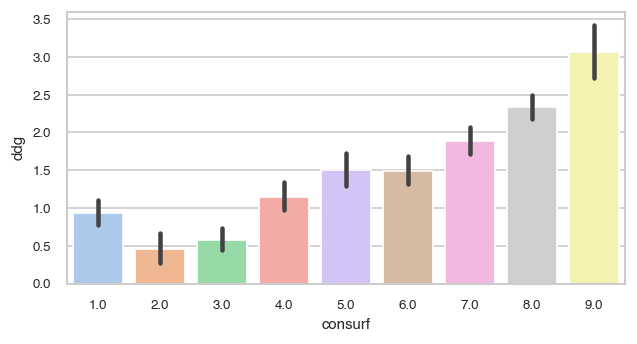

In [70]:
sns.barplot(data=df, x='consurf', y='ddg')

<AxesSubplot:xlabel='consurf', ylabel='ddg'>

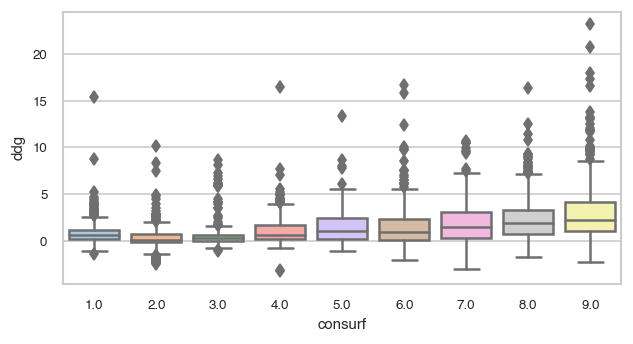

In [79]:
# sns.violinplot(data=df, x='consurf', y='ddg', width=1)
# cap at 15, as 1 ddg ~ 3 kcal/mol

sns.boxplot(data=df, x='consurf', y='ddg')

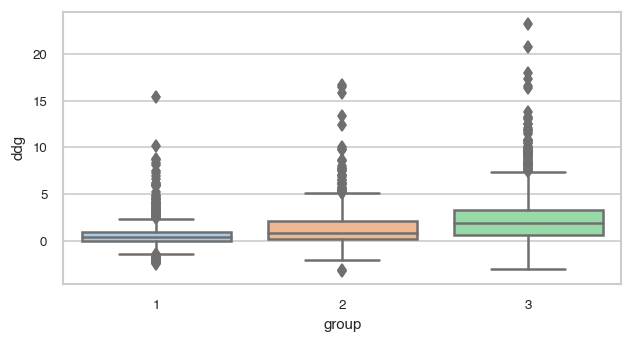

In [80]:
g3=(df
 .assign(group = lambda df: df.consurf.apply(lambda x: 3 if x>6 else (2 if x>3 else 1)))
 .pipe((sns.boxplot, 'data'), x='group', y='ddg')
)


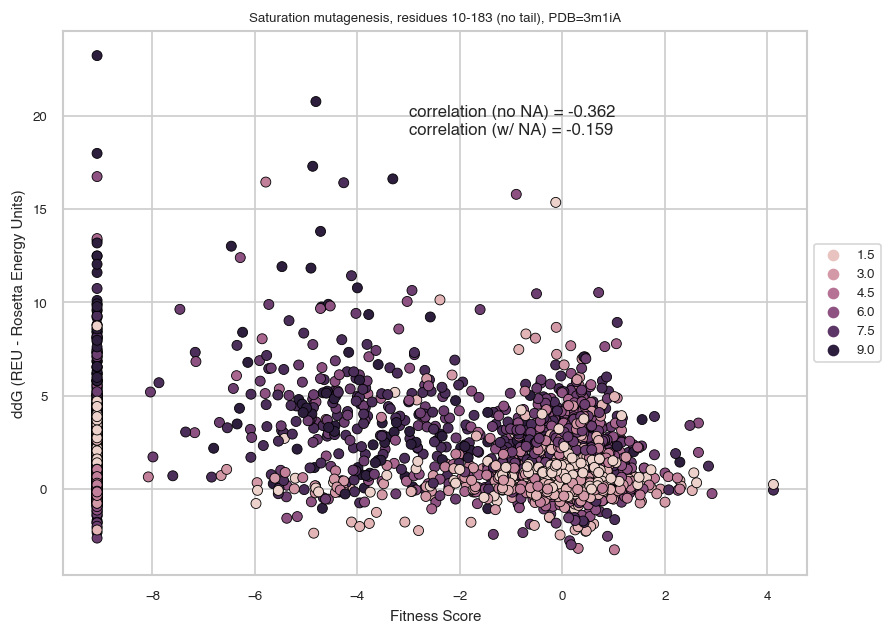

In [73]:
# prepare figure
fig, ax = plt.subplots(figsize=(8,6))



sns.scatterplot(data=df, x='fitness', y='ddg', hue='consurf',
#                 hue_order = bin_ordering,
#                 palette=[(0,0,0)]+sns.color_palette('RdBu', n_colors=7)[:4],
                edgecolor='black', linewidth=0.5
               )

ax.text(-3,20,'correlation (no NA) = {}'.format(round(corr_no_NA,3)))
ax.text(-3,19,'correlation (w/ NA) = {}'.format(round(corr_w_NA,3)))

plt.title('Saturation mutagenesis, residues 10-183 (no tail), PDB=3m1iA')
plt.xlabel('Fitness Score')
plt.ylabel('ddG (REU - Rosetta Energy Units)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# fig.tight_layout(rect=[0, 0, 1, 1])
# fig.savefig('satmut_ddG_2020-07-26.png', dpi=300)

In [74]:
# restrict to only interface positions

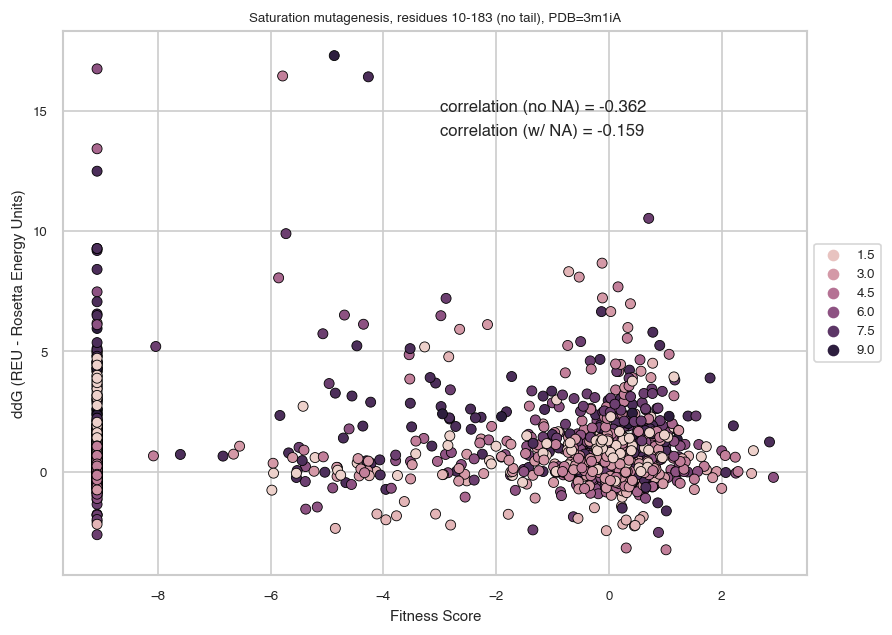

In [75]:
# prepare figure
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data=df[df['sasa_group_category'] == 'interface core'],
                x='fitness', y='ddg', hue='consurf',
#                 hue_order = bin_ordering,
#                 palette=[(0,0,0)]+sns.color_palette('RdBu', n_colors=7)[:4],
                edgecolor='black', linewidth=0.5
               )

ax.text(-3,15,'correlation (no NA) = {}'.format(round(corr_no_NA,3)))
ax.text(-3,14,'correlation (w/ NA) = {}'.format(round(corr_w_NA,3)))

plt.title('Saturation mutagenesis, residues 10-183 (no tail), PDB=3m1iA')
plt.xlabel('Fitness Score')
plt.ylabel('ddG (REU - Rosetta Energy Units)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# fig.tight_layout(rect=[0, 0, 1, 1])
# fig.savefig('satmut_ddG_2020-07-26.png', dpi=300)